### Compare fits for pct_high, pct_low, ... etc

#### 'Disabling' numba has no effect
import os
check = os.environ.get("ARCH_DISABLE_NUMBA", True)

In [107]:
from sqlalchemy import create_engine
engine = create_engine('mysql+pymysql://localhost',
                       connect_args={'read_default_file': '~/.myuseq.cnf'})
conn = engine.connect()

Get List of Tickers from SandP 500. Returned as DataFrame tdf

In [108]:
# Limit number of stocks for testing
num_stocks="50"

import pandas as pd
tck_qry = pd.read_sql_query('''select symbol from SandP500 limit ''' + num_stocks,
                            conn)
tdf = pd.DataFrame(tck_qry, columns=['symbol'])
tickers = tdf['symbol']
prices = ["pct_open", "pct_high", "pct_low", "pct_close",
          'pct_hilo', 'pct_opclo']
#prices = ["pct_hilo"]

#### Get Timeseries for tickers, price types 
##### Query Function

In [109]:
def query_symbol(sym, conn):
    qry = pd.read_sql_query(
        '''select tradedate, pct_open, pct_high, pct_low, pct_close,
         pct_hilo, pct_opclo from USEQ_HIST
        where symbol="''' + sym + '''"
        and volume>0
         order by tradedate''',
        conn,
        index_col='tradedate'
    )
    return sym, pd.DataFrame(qry, columns=prices)

In [110]:
import math
def ann_var(var):
    return (math.sqrt((var)*252))

In [111]:
from arch import arch_model

In [112]:
def calc_arch(ticks,prices,conn):
    rows = []
    #tickers=pd.concat([pd.Series(data='DFS'), tickers])
    for tk in ticks:
        ticker, df = query_symbol(tk, conn)
        for pr in prices:
            if(len(df.index)<800):
                continue
        
            am = arch_model(df[pr], p=1, o=1, q=1, dist="Studentst", rescale=False)
            res = am.fit(disp='off')
            if res.convergence_flag != 0:
                continue
            forecasts = res.forecast(reindex=False)
            row = [tk, pr, res.loglikelihood, ann_var(forecasts.variance['h.1'].iloc[0])
               ,forecasts.mean['h.1'].iloc[0], res.nobs]
            rows.append(row)
    return rows
 

In [113]:
  
# rows -> DataFrame cmp
cmp = pd.DataFrame(calc_arch(tickers, prices, conn), columns=['ticker', 'price', 'lhood', 'volatilty', 'mean', 'nobs'])

compare = cmp.set_index(['ticker','price'])
compare.head(36)

lhood  volatilty      mean  nobs
ticker price                                             
MMM    pct_open   -9602.009768  70.610901  0.045586  5913
       pct_high   -8852.732338  69.577244  0.044612  5913
       pct_low    -9320.424555  74.167059  0.041254  5913
       pct_close  -9740.528438  71.468202  0.047788  5913
       pct_hilo   -7150.874090  13.102290  1.414492  5913
       pct_opclo  -8695.698888  16.212439 -0.037954  5913
AOS    pct_open  -11672.626793  82.613553  0.074756  5913
       pct_high  -11086.374575  65.049377  0.076329  5913
       pct_low   -11358.452976  86.151895  0.060529  5913
       pct_close -11794.732648  81.313968  0.066858  5913
       pct_hilo   -9622.962976  15.054936  1.974305  5913
       pct_opclo -11013.394574  18.854694 -0.024371  5913
ABT    pct_open   -9853.840805  24.881758  0.029805  5913
       pct_high   -8981.622468  19.492822  0.047562  5913
       pct_low    -9464.054729  24.639308  0.026431  5913
       pct_close  -9836.339486  19.832400  0.040485  5913
       pct_hilo   -7466.176311  12.976763  1.513893  5913
       pct_opclo  -9100.528210  17.078480 -0.041279  5913
ABBV   pct_open   -5184.456609  34.313182  0.109137  2896
       pct_high   -4884.141642  31.559969  0.094619  2896
       pct_low    -5100.278472  29.163942  0.110934  2896
       pct_close  -5181.099469  29.517269  0.103121  2896
       pct_hilo   -3967.389689  13.481735  1.759795  2896
       pct_opclo  -4785.068775  19.978050 -0.079011  2896
ACN    pct_open  -10600.042278  71.624330  0.079417  5776
       pct_high   -9888.871092  64.622624  0.079754  5776
       pct_low   -10313.450604  50.210755  0.083778  5776
       pct_close -10576.212487  57.166878  0.080223  5776
       pct_hilo   -8462.996734  18.288022  1.598204  5776
       pct_opclo  -9657.422968  21.687194 -0.112120  5776
ATVI   pct_open   -2961.005140  20.019963  0.080261  1510
       pct_high   -2769.573511  19.436251  0.074987  1510
       pct_low    -2838.452198  21.005279  0.082139  1510
       pct_close  -2962.961390  18.316723  0.068946  1510
       pct_hilo   -2415.525733  24.556040  2.105608  1510
       pct_opclo  -2734.044536  14.117557 -0.000395  1510

<Axes: ylabel='Frequency'>

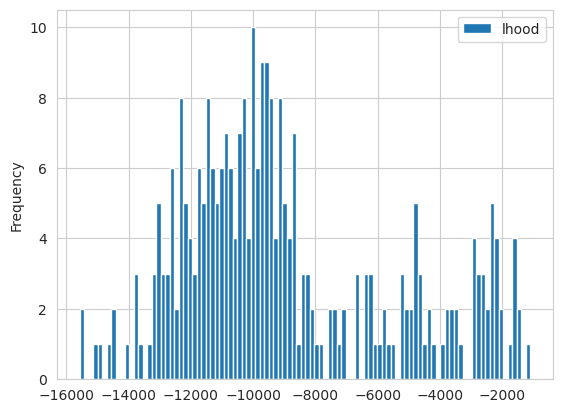

In [114]:
compare[['lhood']].plot(bins=100, kind='hist')

<Axes: ylabel='Frequency'>

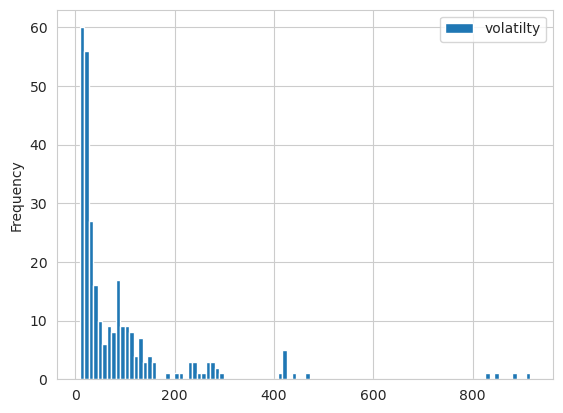

In [115]:
compare[['volatilty']].plot(bins=100, kind='hist')

In [116]:
conn.close()